<a href="https://colab.research.google.com/github/ankita94sahoo/age_of_information/blob/master/Bitcoin_Analaysis_Gillebert_elliot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
import numpy as np #linear algebra
import pandas as pd #data processing, CSV files I/O
import matplotlib.pyplot as plt

from plotly import tools
import plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import gc

from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Data Loading and Preprocessing step

In [3]:
import datetime, pytz
#define a conversion function for the native timestamps in the csv file
def dateparse (time_in_secs):    
    return pytz.utc.localize(datetime.datetime.fromtimestamp(float(time_in_secs)))
    
bitcoin = pd.read_csv('/content/drive/MyDrive/Semester Project/coinbaseUSD_1-min_data_2014-12-01_to_2018-11-11.csv.zip',
                   index_col=[0], parse_dates=[0]) # We set the index column and know it has dates

In [4]:
bitcoin.head(5)

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
1417411980,300.0,300.0,300.0,300.0,0.01,3.0,300.0
1417412040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1417412100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1417412160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1417412220,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# First thing is to fix the data for bars/candles where there are no trades. 
# Volume/trades are a single event so fill na's with zeroes for relevant fields...
bitcoin['Volume_(BTC)'].fillna(value=0, inplace=True)
bitcoin['Volume_(Currency)'].fillna(value=0, inplace=True)
bitcoin['Weighted_Price'].fillna(value=0, inplace=True)

# next we need to fix the OHLC (open high low close) data which is a continuous timeseries so
# lets fill forwards those values...
bitcoin['Open'].fillna(method='ffill', inplace=True)
bitcoin['High'].fillna(method='ffill', inplace=True)
bitcoin['Low'].fillna(method='ffill', inplace=True)
bitcoin['Close'].fillna(method='ffill', inplace=True)

bitcoin.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
1417411980,300.0,300.0,300.0,300.0,0.01,3.0,300.0
1417412040,300.0,300.0,300.0,300.0,0.00,0.0,0.0
1417412100,300.0,300.0,300.0,300.0,0.00,0.0,0.0
1417412160,300.0,300.0,300.0,300.0,0.00,0.0,0.0
1417412220,300.0,300.0,300.0,300.0,0.00,0.0,0.0


In [6]:
# Creating Weekly Rows for the Data Visualization
# create valid date range
start = datetime.datetime(2015, 1, 1, 0, 0, 0, 0, pytz.UTC)
end = datetime.datetime(2018, 11, 11, 0, 0, 0, 0, pytz.UTC)

In [7]:
bitcoin.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
1417411980,300.0,300.0,300.0,300.0,0.01,3.0,300.0
1417412040,300.0,300.0,300.0,300.0,0.00,0.0,0.0
1417412100,300.0,300.0,300.0,300.0,0.00,0.0,0.0
1417412160,300.0,300.0,300.0,300.0,0.00,0.0,0.0
1417412220,300.0,300.0,300.0,300.0,0.00,0.0,0.0


In [8]:
# data['Timestamp']=data.index
bitcoin= bitcoin.reset_index()
bitcoin.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1417411980,300.0,300.0,300.0,300.0,0.01,3.0,300.0
1,1417412040,300.0,300.0,300.0,300.0,0.00,0.0,0.0
2,1417412100,300.0,300.0,300.0,300.0,0.00,0.0,0.0
3,1417412160,300.0,300.0,300.0,300.0,0.00,0.0,0.0
4,1417412220,300.0,300.0,300.0,300.0,0.00,0.0,0.0


In [9]:
bitcoin['Timestamp'] = bitcoin['Timestamp'].apply(dateparse)

In [10]:
# find rows between start and end time and find the first row (00:00 monday morning)
weekly_rows = bitcoin[(bitcoin['Timestamp'] >= start) & (bitcoin['Timestamp'] <= end)].groupby([pd.Grouper(key='Timestamp', freq='W-MON')]).first().reset_index()
# weekly_rows= weekly_rows.drop(['Timestamp_final'],axis=1)
weekly_rows.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2015-01-12 00:00:00+00:00,360.00,360.00,360.00,360.00,0.0100,3.600000,360.00
1,2015-01-19 00:00:00+00:00,260.00,260.00,260.00,260.00,1.0000,260.000000,260.00
2,2015-01-26 00:00:00+00:00,225.51,225.51,225.51,225.51,0.0000,0.000000,0.00
3,2015-02-02 00:00:00+00:00,274.73,274.73,274.73,274.73,0.2428,66.704444,274.73
4,2015-02-09 00:00:00+00:00,237.83,237.83,237.83,237.83,0.0000,0.000000,0.00


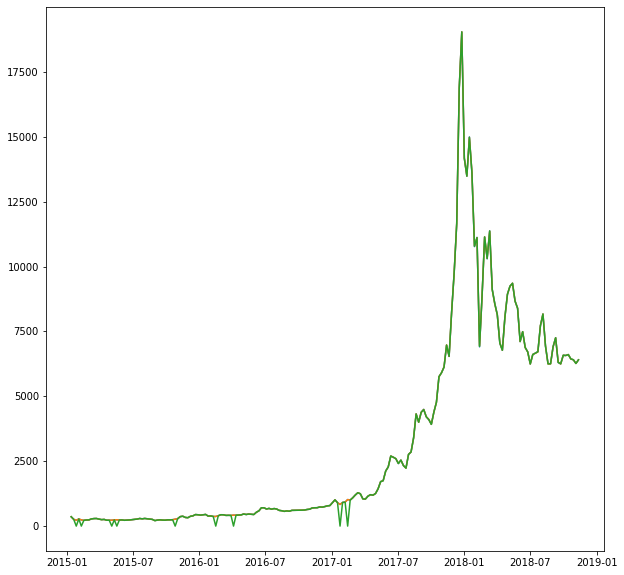

In [11]:
#Historical Bitcoin Prices (2015-2018)
fig,(ax1) = plt.subplots(1,sharex=True, figsize=(10,10))
x = weekly_rows['Timestamp']
y = weekly_rows['Open']

x1 = weekly_rows['Timestamp']
y1 = weekly_rows['Close']

x2 = weekly_rows['Timestamp']
y2 = weekly_rows['Weighted_Price']

ax1.plot(x,y)
ax1.plot(x1,y1)
ax1.plot(x2,y2)

Delayed and Channel transmitted data

In [12]:
import datetime, pytz
#define a conversion function for the native timestamps in the csv file
def dateparse (time_in_secs):    
    return pytz.utc.localize(datetime.datetime.fromtimestamp(float(time_in_secs)))
    
processed_data = pd.read_csv("/content/drive/MyDrive/Semester Project/Recieved_file_bitcoin_p0.7.csv",
                   index_col=[0], parse_dates=[0]) # We set the index column and know it has dates

In [13]:
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 806736 entries, 0.0 to 100052.0
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Timestamp          806736 non-null  object
 1   Open               765369 non-null  object
 2   High               765369 non-null  object
 3   Low                765369 non-null  object
 4   Close              765369 non-null  object
 5   Volume_(BTC)       765369 non-null  object
 6   Volume_(Currency)  765369 non-null  object
 7   Weighted_Price     765369 non-null  object
 8   delay              806736 non-null  object
dtypes: object(9)
memory usage: 61.5+ MB


In [14]:
#Preprocessing Received data
# First thing is to fix the data for bars/candles where there are no trades. 
# Volume/trades are a single event so fill na's with zeroes for relevant fields...
processed_data['Volume_(BTC)'].fillna(value=0, inplace=True)
processed_data['Volume_(Currency)'].fillna(value=0, inplace=True)
processed_data['Weighted_Price'].fillna(value=0, inplace=True)

# next we need to fix the OHLC (open high low close) data which is a continuous timeseries so
# lets fill forwards those values...
processed_data['Open'].fillna(method='ffill', inplace=True)
processed_data['High'].fillna(method='ffill', inplace=True)
processed_data['Low'].fillna(method='ffill', inplace=True)
processed_data['Close'].fillna(method='ffill', inplace=True)

processed_data.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,delay
0.0,1417411980,300.0,300.0,300.0,300.0,0.01,3.0,300.0,0
1.0,1417412040,300.0,300.0,300.0,300.0,0,0,0,1
2.0,1417412100,300.0,300.0,300.0,300.0,0,0,0,2
3.0,1417412160,300.0,300.0,300.0,300.0,0,0,0,3
4.0,1417412220,300.0,300.0,300.0,300.0,0,0,0,4


In [15]:
processed_data = processed_data[processed_data.Open != "Open"]
processed_data.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,delay
0.0,1417411980,300.0,300.0,300.0,300.0,0.01,3.0,300.0,0
1.0,1417412040,300.0,300.0,300.0,300.0,0,0,0,1
2.0,1417412100,300.0,300.0,300.0,300.0,0,0,0,2
3.0,1417412160,300.0,300.0,300.0,300.0,0,0,0,3
4.0,1417412220,300.0,300.0,300.0,300.0,0,0,0,4


In [16]:
# data['Timestamp']=data.index
processed_data= processed_data.reset_index()
processed_data.head()

,index,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,delay
0,0.0,1417411980,300.0,300.0,300.0,300.0,0.01,3.0,300.0,0
1,1.0,1417412040,300.0,300.0,300.0,300.0,0,0,0,1
2,2.0,1417412100,300.0,300.0,300.0,300.0,0,0,0,2
3,3.0,1417412160,300.0,300.0,300.0,300.0,0,0,0,3
4,4.0,1417412220,300.0,300.0,300.0,300.0,0,0,0,4


In [17]:
processed_data['Timestamp'] = processed_data['Timestamp'].apply(dateparse)

In [18]:
# find rows between start and end time and find the first row (00:00 monday morning)
weekly_rows_delayed = processed_data[(processed_data['Timestamp'] >= start) & (processed_data['Timestamp'] <= end)].groupby([pd.Grouper(key='Timestamp', freq='W-MON')]).first().reset_index()
# weekly_rows= weekly_rows.drop(['Timestamp_final'],axis=1)
weekly_rows_delayed.head()

,Timestamp,index,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,delay
0,2015-01-12 00:00:00+00:00,4122.0,295.19,319.84,271.6,271.6,0.03,8.8663,295.54333333,1595
1,2015-01-19 00:00:00+00:00,10630.0,206.95,206.95,198.08,198.19,0.03,6.0322,201.07333333,4219
2,2015-01-26 00:00:00+00:00,14406.0,215.0,215.0,215.0,215.0,0.01,2.15,215.0,5707
3,2015-02-02 00:00:00+00:00,23393.0,274.73,274.73,274.73,274.73,0.2428,66.704444,274.73,9307
4,2015-02-09 00:00:00+00:00,33475.0,237.01,237.01,237.0,237.0,0.519,123.0033,237.00057803,13358


In [19]:
processed_data['Delayed_Time']= processed_data.index.copy()
processed_data.head()

,index,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,delay,Delayed_Time
0,0.0,2014-12-01 05:33:00+00:00,300.0,300.0,300.0,300.0,0.01,3.0,300.0,0,0
1,1.0,2014-12-01 05:34:00+00:00,300.0,300.0,300.0,300.0,0,0,0,1,1
2,2.0,2014-12-01 05:35:00+00:00,300.0,300.0,300.0,300.0,0,0,0,2,2
3,3.0,2014-12-01 05:36:00+00:00,300.0,300.0,300.0,300.0,0,0,0,3,3
4,4.0,2014-12-01 05:37:00+00:00,300.0,300.0,300.0,300.0,0,0,0,4,4


In [20]:
processed_data['Delayed_Time'] = processed_data.Timestamp + processed_data.delay.astype('timedelta64[s]') #to convert delay to seconds
processed_data.head(5)

,index,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,delay,Delayed_Time
0,0.0,2014-12-01 05:33:00+00:00,300.0,300.0,300.0,300.0,0.01,3.0,300.0,0,2014-12-01 05:33:00+00:00
1,1.0,2014-12-01 05:34:00+00:00,300.0,300.0,300.0,300.0,0,0,0,1,2014-12-01 05:34:01+00:00
2,2.0,2014-12-01 05:35:00+00:00,300.0,300.0,300.0,300.0,0,0,0,2,2014-12-01 05:35:02+00:00
3,3.0,2014-12-01 05:36:00+00:00,300.0,300.0,300.0,300.0,0,0,0,3,2014-12-01 05:36:03+00:00
4,4.0,2014-12-01 05:37:00+00:00,300.0,300.0,300.0,300.0,0,0,0,4,2014-12-01 05:37:04+00:00


Feature Extraction

In [21]:
bitcoin.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2014-12-01 05:33:00+00:00,300.0,300.0,300.0,300.0,0.01,3.0,300.0
1,2014-12-01 05:34:00+00:00,300.0,300.0,300.0,300.0,0.00,0.0,0.0
2,2014-12-01 05:35:00+00:00,300.0,300.0,300.0,300.0,0.00,0.0,0.0
3,2014-12-01 05:36:00+00:00,300.0,300.0,300.0,300.0,0.00,0.0,0.0
4,2014-12-01 05:37:00+00:00,300.0,300.0,300.0,300.0,0.00,0.0,0.0


In [22]:
#Feature Extraction of Fresh data
bitcoin['Timestamp'] = bitcoin['Timestamp'].dt.tz_localize(None)
bitcoin = bitcoin.groupby([pd.Grouper(key='Timestamp', freq='H')]).first().reset_index()
bitcoin = bitcoin.set_index('Timestamp')
bitcoin = bitcoin[['Weighted_Price']]
bitcoin['Weighted_Price'].fillna(method='ffill', inplace=True)

In [23]:
bitcoin.head(-5)

,Weighted_Price
Timestamp,
2014-12-01 05:00:00,300.000000
2014-12-01 06:00:00,0.000000
2014-12-01 07:00:00,0.000000
2014-12-01 08:00:00,0.000000
2014-12-01 09:00:00,0.000000
...,...
2018-11-10 15:00:00,6364.458212
2018-11-10 16:00:00,6362.818959
2018-11-10 17:00:00,6369.989366


In [24]:
#Feature Extraction of delayed data 
processed_data['Delayed_Time'] = processed_data['Delayed_Time'].dt.tz_localize(None)
processed_data = processed_data.groupby([pd.Grouper(key='Delayed_Time', freq='H')]).first().reset_index()
processed_data = processed_data.set_index('Delayed_Time')
processed_data = processed_data[['Weighted_Price']]
processed_data['Weighted_Price'].fillna(method='ffill', inplace=True)

In [25]:
processed_data.head(-5)

,Weighted_Price
Delayed_Time,
2014-12-01 05:00:00,300.0
2014-12-01 06:00:00,0
2014-12-01 07:00:00,0
2014-12-01 08:00:00,0
2014-12-01 09:00:00,0
...,...
2018-11-19 22:00:00,6365.51
2018-11-19 23:00:00,6364.4532342
2018-11-20 00:00:00,6362.8267594


Splitting Dataset into Train and Test

In [37]:
# split data
split_date = '25-06-2018'
# from datetime import datetime
# split_date_obj = datetime. strptime(split_date, "%d-%m-%Y %H:%M:%S")
data_train_fresh = bitcoin.loc[bitcoin.index <= split_date].copy()
data_test_fresh = bitcoin.loc[bitcoin.index > split_date].copy()

In [38]:
#Checking the length of dataset
print('DataSet length =',len(bitcoin))
print('Train dataset length =',len(data_train_fresh))
print('Test dataset length =',len(data_test_fresh))

DataSet length = 34580
Train dataset length = 31244
Test dataset length = 3336


In [39]:
data_train_fresh.head()

,Weighted_Price
Timestamp,
2014-12-01 05:00:00,300.0
2014-12-01 06:00:00,0.0
2014-12-01 07:00:00,0.0
2014-12-01 08:00:00,0.0
2014-12-01 09:00:00,0.0


In [40]:
# Data preprocess
training_set_fresh = data_train_fresh.values
training_set_fresh = np.reshape(training_set_fresh, (len(training_set_fresh), 1))
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
training_set_fresh = sc.fit_transform(training_set_fresh)
X_train_fresh = training_set_fresh[0:len(training_set_fresh)-1]
y_train_fresh = training_set_fresh[1:len(training_set_fresh)]
X_train_fresh = np.reshape(X_train_fresh, (len(X_train_fresh), 1, 1))

In [41]:
# split Delayed Data
split_date = '25-06-2018'
# from datetime import datetime
# split_date_obj = datetime. strptime(split_date, "%d-%m-%Y %H:%M:%S")
data_train_delay = processed_data.loc[processed_data.index <= split_date].copy()
data_test_delay = processed_data.loc[processed_data.index > split_date].copy()

In [46]:
data_train_delay.head()

,Delayed_Time,y
0,2014-12-01 05:00:00,300.0
1,2014-12-01 06:00:00,0
2,2014-12-01 07:00:00,0
3,2014-12-01 08:00:00,0
4,2014-12-01 09:00:00,0


In [42]:
#Checking the length of dataset
print('DataSet length =',len(processed_data))
print('Train dataset length =',len(data_train_delay))
print('Test dataset length =',len(data_test_delay))

DataSet length = 34803
Train dataset length = 31244
Test dataset length = 3559


In [43]:
len(bitcoin)

34580

In [44]:
data_train_fresh = data_train_fresh.reset_index().rename(columns={'Timestamp':'ds', 'Weighted_Price':'y'})

In [47]:
data_train_delay = data_train_delay.reset_index().rename(columns={'Delayed_Time':'ds', 'Weighted_Price':'y'})

In [54]:
# Setup and train model on Fresh data
model = Prophet()
model.fit(data_train_fresh)

In [ ]:
# Setup and train model on Delay data
# model = Prophet()
# model.fit(data_train_delay)

In [55]:
# Predict on training set with model
data_test_fcst = model.predict(df=data_test_fresh.reset_index().rename(columns={'Timestamp':'ds'}))

In [56]:
data_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-06-25 01:00:00,8317.686521,5637.331510,7259.373088,8317.686521,8317.686521,-1846.455626,-1846.455626,-1846.455626,13.075973,13.075973,13.075973,-1.840458,-1.840458,-1.840458,-1857.691140,-1857.691140,-1857.691140,0.0,0.0,0.0,6471.230895
1,2018-06-25 02:00:00,8317.773717,5537.915246,7367.842756,8317.773717,8317.773717,-1852.846992,-1852.846992,-1852.846992,8.873006,8.873006,8.873006,-1.493532,-1.493532,-1.493532,-1860.226466,-1860.226466,-1860.226466,0.0,0.0,0.0,6464.926725
2,2018-06-25 03:00:00,8317.860913,5582.469166,7302.396687,8317.860913,8317.860913,-1862.070215,-1862.070215,-1862.070215,1.766087,1.766087,1.766087,-1.077041,-1.077041,-1.077041,-1862.759261,-1862.759261,-1862.759261,0.0,0.0,0.0,6455.790698
3,2018-06-25 04:00:00,8317.948109,5608.185985,7260.361062,8317.948109,8317.948109,-1872.340228,-1872.340228,-1872.340228,-6.453793,-6.453793,-6.453793,-0.596939,-0.596939,-0.596939,-1865.289496,-1865.289496,-1865.289496,0.0,0.0,0.0,6445.607882
4,2018-06-25 05:00:00,8318.035306,5516.863212,7319.559715,8318.035306,8318.035306,-1881.503562,-1881.503562,-1881.503562,-13.626603,-13.626603,-13.626603,-0.059819,-0.059819,-0.059819,-1867.817141,-1867.817141,-1867.817141,0.0,0.0,0.0,6436.531743


In [52]:
#Predict on Delayed Data set with Model
# data_test_delay_fcst = model.predict(df=data_test_delay.reset_index().rename(columns={'Delayed_Time':'ds'}))

Metrics 

In [57]:
#Metrics to check Fresh Test data
mean_squared_error(y_true=data_test_fresh['Weighted_Price'],
                   y_pred=data_test_fcst['yhat'])

2599960.1130949664

In [59]:
#Metrics to check Fresh Test data
mean_absolute_error(y_true=data_test_fresh['Weighted_Price'],
                   y_pred=data_test_fcst['yhat'])

1401.0729536845101

In [ ]:
#Metrics to check Delayed Test data
# mean_squared_error(y_true=data_test_delay['Weighted_Price'],
#                    y_pred=data_test_delay_fcst['yhat'])

In [ ]:
#Metrics to check Fresh Test data
mean_absolute_error(y_true=data_test_fresh['Weighted_Price'],
                   y_pred=data_test_fcst['yhat'])